## **Shielf Insurance Premium Predictor**

**Import Required Libraries**

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### **Data Cleaning & EDA - Part 1**

**Explore Dataset**

In [163]:
df = pd.read_excel("premiums_young_with_gr.xlsx")
print(df.shape)
df.head(4)

(20096, 14)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2


In [248]:
df.dtypes

age                       int64
gender                   object
region                   object
marital_status           object
number_of_dependants      int64
bmi_category             object
smoking_status           object
employment_status        object
income_level             object
income_lakhs              int64
medical_history          object
insurance_plan           object
annual_premium_amount     int64
genetical_risk            int64
dtype: object

In [165]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

**Normalize Column Titles**

In [166]:
df.columns.str.replace(' ','_')

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number_Of_Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical_History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'Genetical_Risk'],
      dtype='object')

In [167]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [168]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

### **Handle NAN Values**

In [169]:
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [170]:
# Since null values are very few compared to dataset, we can just drop them
df.dropna(inplace=True)
df.isnull().sum()
df.shape

(20090, 14)

**Check & Handle Duplicates**

In [171]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [172]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


**Let's Treat Negative Values in Number of Dependants**

In [173]:
df[df['number_of_dependants']<0].shape

(22, 14)

In [174]:
df[df['number_of_dependants']<0].number_of_dependants.unique()

# It seems the negative values might have been due to typo, so we can apply absolute function

array([-3, -1], dtype=int64)

In [175]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [176]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


**Check Distribution of Numerical Features**

In [177]:
# This is how to fetch all numeric columns in your dataset

df.select_dtypes(['float64', 'int64'])

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
0,18,0,99,13365,4
1,22,0,3,11050,3
2,21,0,97,11857,4
3,25,0,15,5684,2
4,20,2,14,5712,1
...,...,...,...,...,...
20091,18,0,91,11603,1
20092,23,0,57,14498,2
20093,24,0,35,9111,5
20094,21,0,32,8564,4


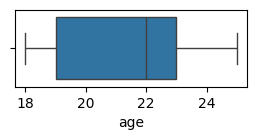

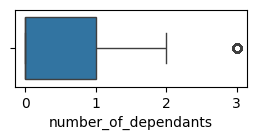

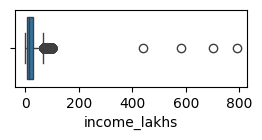

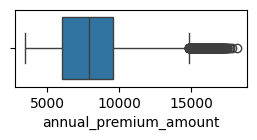

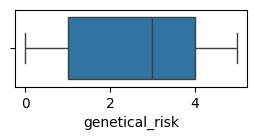

In [178]:
numerical_features = df.select_dtypes(['float64', 'int64']).columns

for feature in numerical_features:
    plt.figure(figsize=(3,1))
    sns.boxplot(x = df[feature])
    

**Treat Outliers in Age Using Threshold (max_Age=100)**

In [179]:
df[df.age>100].age.unique()

array([], dtype=int64)

In [180]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


**Treat Outliers in Income Using IQR**

<Axes: >

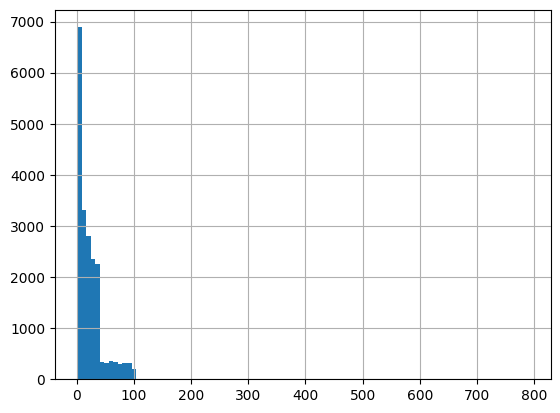

In [181]:
df1['income_lakhs'].hist(bins=100)

In [182]:
df1['income_lakhs'].quantile([0.25,0.75])


0.25     6.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [183]:
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [184]:
get_iqr_bounds(df1.income_lakhs)

# we won't worry on the lower_bound rather on the upper bound, 67, which is not that extreme

(-31.5, 68.5)

In [185]:
# Rather we can choose to set a threshold

quantile_threshold = df1['income_lakhs'].quantile(0.999)
quantile_threshold

100.0

In [186]:
df1[df1['income_lakhs']>quantile_threshold]

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
1677,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636,3
4311,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888,5
4661,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424,3
6251,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586,0


In [187]:
# Since just a total of 10 people has income above the set threshold, we can then decide to drop them

df2 = df1[df1['income_lakhs']<=quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


#### **Data Cleaning & EDA - Part 2**

**View Numerical Data on Histogram: Univariate Analysis**

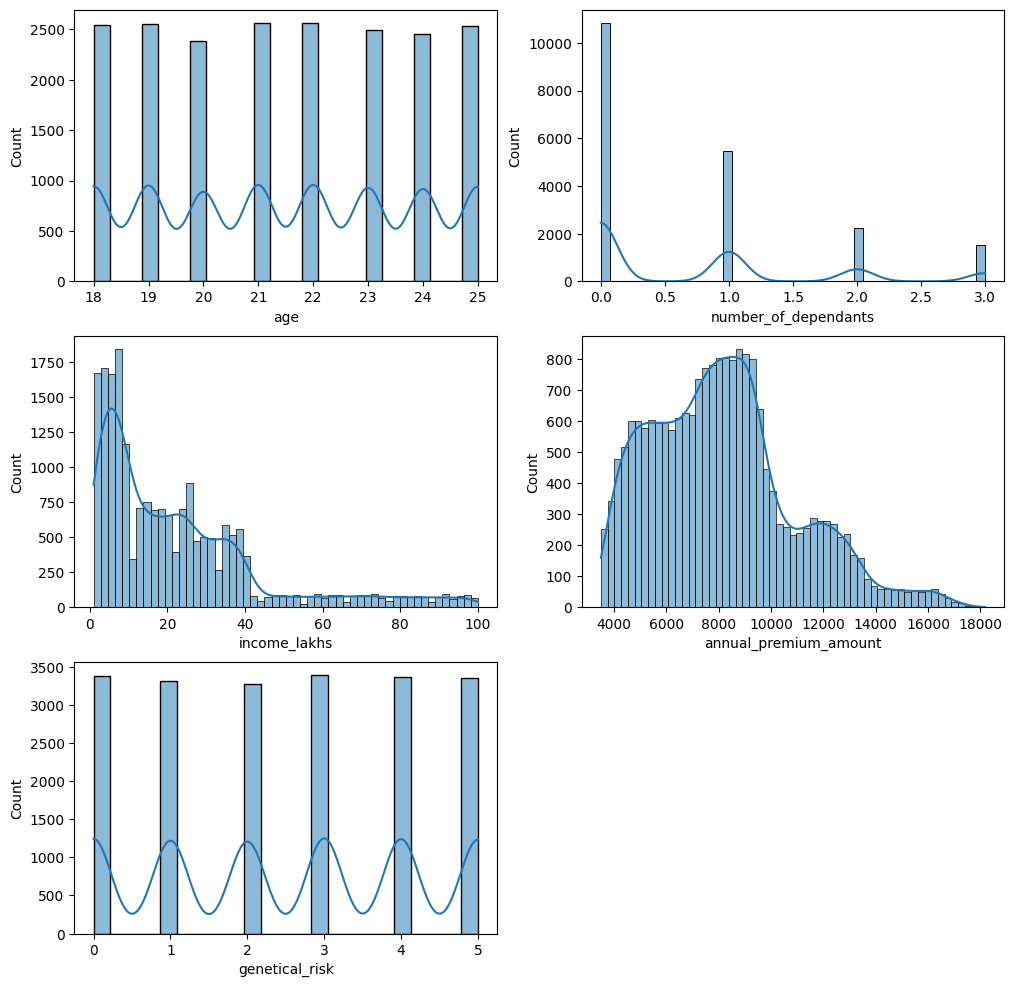

In [188]:
numerical_features = df2.select_dtypes(['float64', 'int64']).columns

n = len(numerical_features)

fig, axes = plt.subplots(3,2,figsize=(12,12))
axes = axes.flatten()

for i,feature in enumerate(numerical_features):
    sns.histplot(data = df2, x = feature, kde=True, ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=10)

for j in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[j])
plt.show()

**Bivariate Analysis of Numerical Features w.r.t annual_premium_income**

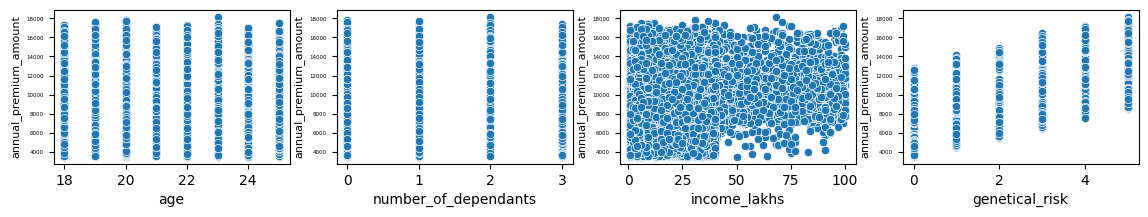

In [189]:
numerical_features = df2.select_dtypes(['float64', 'int64']).columns
bivariate_features = numerical_features.drop('annual_premium_amount')


fig, axes = plt.subplots(1,4,figsize=(14,2))
axes = axes.flatten()

for i,feature in enumerate(bivariate_features):
    sns.scatterplot(data = df2, x=feature, y='annual_premium_amount', ax=axes[i])
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('annual_premium_amount', fontsize=8)
    axes[i].tick_params(axis='y', labelsize=4)
for j in range(len(bivariate_features), len(axes)):
    fig.delaxes(axes[j])

plt.show()


**Categorical Columns EDA**

In [190]:
categorical_features = df2.select_dtypes(['object']).columns
categorical_features
for col in categorical_features:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [191]:
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df2['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

In [192]:
get_count = df2.gender.value_counts(normalize=True)*100
get_count

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

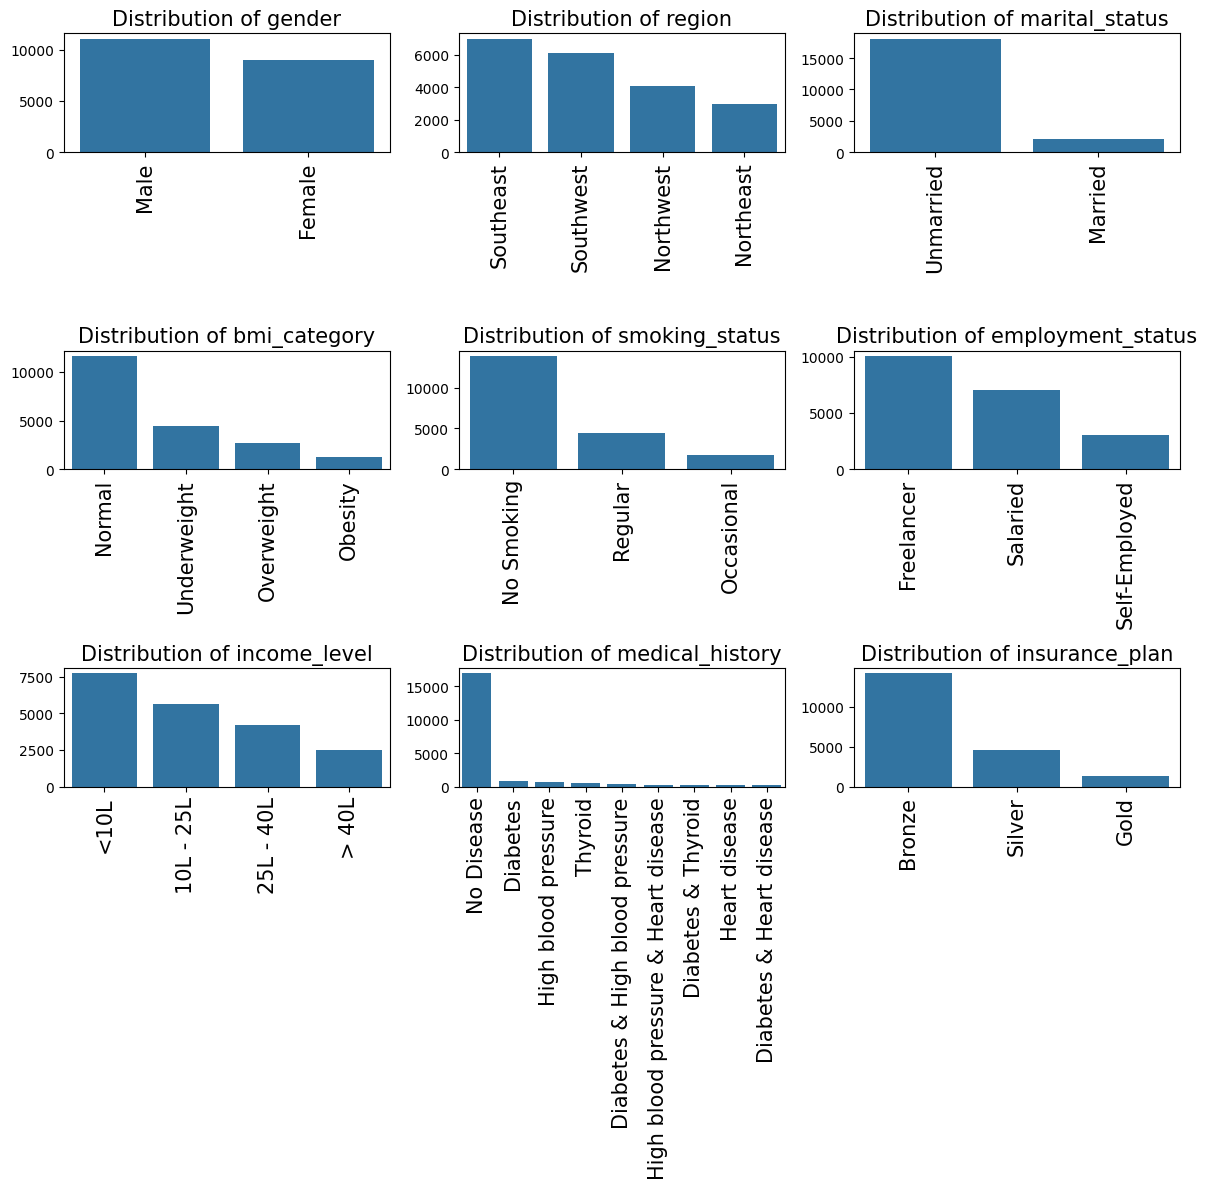

In [193]:
import math
categorical_features = df2.select_dtypes(['object']).columns
n = len(categorical_features)
rows = math.ceil(n / 3)

fig, axes = plt.subplots(rows, 3, figsize=(12,12))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    get_count = df2[col].value_counts()
    sns.barplot(x=get_count.index, y=get_count.values, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=15)
    axes[i].tick_params(axis='x', rotation=90, labelsize=15)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].set_xlabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



**Crosstab ::: Cross Tabulation**

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


<Axes: xlabel='income_level'>

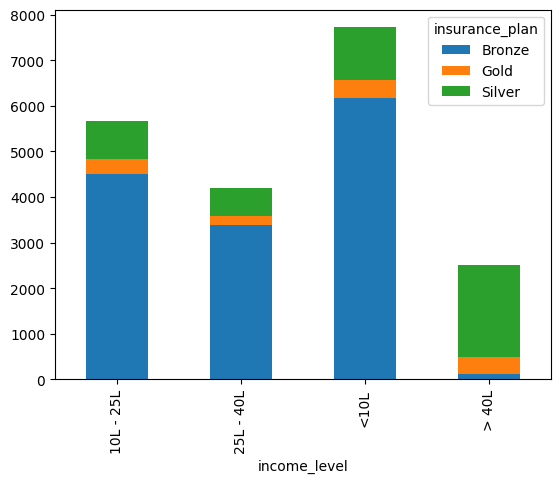

In [194]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar', stacked=True)

<Axes: xlabel='insurance_plan', ylabel='income_level'>

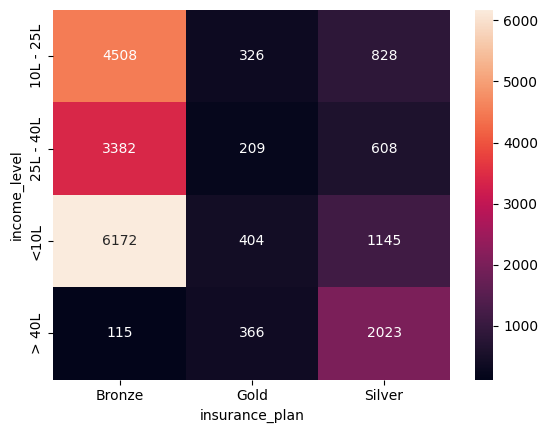

In [195]:
sns.heatmap(crosstab,fmt='d', annot=True)

#### **Feature Engineering: Converting Text to Numbers**

In [196]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


In [197]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

**Normalizing medical_history column**

In [198]:
df2.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [199]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split('&', expand=True).apply(lambda x: x.str.strip().str.lower())
df2.head(4)




,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,None
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,None


In [200]:
df2.isnull().sum()

age                          0
gender                       0
region                       0
marital_status               0
number_of_dependants         0
bmi_category                 0
smoking_status               0
employment_status            0
income_level                 0
income_lakhs                 0
medical_history              0
insurance_plan               0
annual_premium_amount        0
genetical_risk               0
disease1                     0
disease2                 19082
dtype: int64

In [201]:
df2[df2['disease2'].isnull()].shape

(19082, 16)

In [202]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)



In [203]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
disease1                 0
disease2                 0
total_risk_score         0
dtype: int64

**Scale Total Risk Score with MinMaxScaler Approach**

In [204]:
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score)/(max_score - min_score)
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2,no disease,none,0,0.000000


**Normalizing insurance_plan column**

In [205]:
df2.insurance_plan.unique()

# # It's more like an ordinal categorical variable

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [206]:
df2['insurance_plan'] = df2.insurance_plan.map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,1,5684,2,no disease,none,0,0.000000


In [207]:
# df2[df2['normalized_risk_score'].isnull()]

**Normalizing income_level column**

In [208]:
df2.income_level.unique()

array(['> 40L', '<10L', '10L - 25L', '25L - 40L'], dtype=object)

In [209]:
df2['income_level'] = df2.income_level.map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4})

In [210]:
df2.head(4)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,4,99,High blood pressure,2,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,1,3,No Disease,2,11050,3,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,4,97,No Disease,2,11857,4,no disease,none,0,0.000000
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,15,No Disease,1,5684,2,no disease,none,0,0.000000


**Normalizing Nominal columns: One Hot Encoding**

In [211]:
nominal_cols = ['gender',	'region',	'marital_status','bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns = nominal_cols, drop_first = True, dtype=int)
df3.head(4)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,No Disease,1,5684,2,no disease,none,...,1,0,1,0,0,0,0,0,0,0


In [212]:
df4 = df3.drop(['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)

In [213]:
df4.isnull().sum()

age                                0
number_of_dependants               0
income_level                       0
income_lakhs                       0
insurance_plan                     0
annual_premium_amount              0
genetical_risk                     0
normalized_risk_score              0
gender_Male                        0
region_Northwest                   0
region_Southeast                   0
region_Southwest                   0
marital_status_Unmarried           0
bmi_category_Obesity               0
bmi_category_Overweight            0
bmi_category_Underweight           0
smoking_status_Occasional          0
smoking_status_Regular             0
employment_status_Salaried         0
employment_status_Self-Employed    0
dtype: int64

**Feature Selection: Correlation and VIF**

**Correlation**

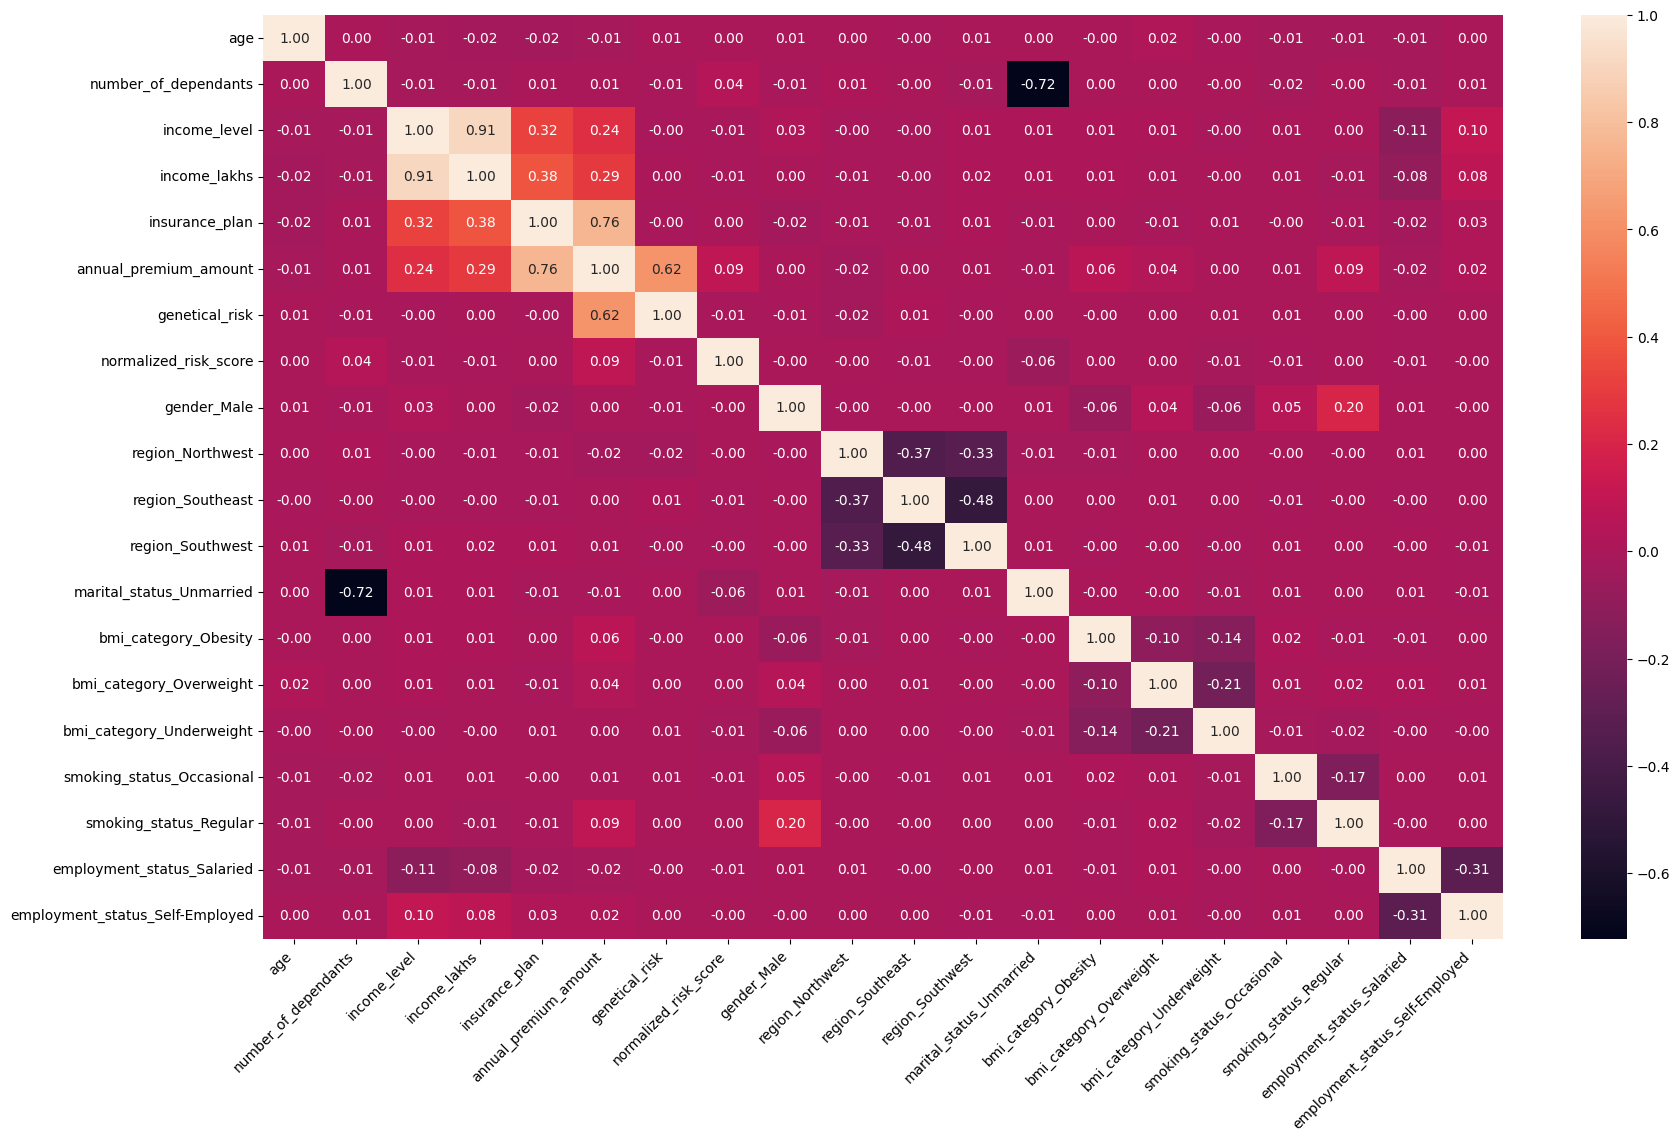

In [214]:
cm = df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm, fmt='.2f', annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**VIF - Process**

In [215]:
df4.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,2,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


In [249]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['age','income_lakhs', 'number_of_dependants' ,'income_level', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head(4)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,1.000000,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.0,0.000000,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.0,1.000000,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.0,0.333333,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


In [250]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [251]:
calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [252]:
# Due to high Correlation between income_level & income_lakhs, 
# We drop the feature with the highest value; income_level

calculate_vif(X.drop('income_level', axis='columns'))

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


In [253]:
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head(4)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.989899,0.5,0.8,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.0,0.020202,0.5,0.6,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.0,0.969697,0.5,0.8,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.0,0.141414,0.0,0.4,0.000000,1,0,1,0,1,0,0,0,0,0,0,0


### **Model Training**

In [254]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (14060, 18)
X_test:  (6026, 18)
y_train:  (14060,)
y_test:  (6026,)


**Train Linear Regression**

In [255]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)
train_score, test_score

# Doing a train_score is to check the performance of both train and test dataset.
# When tran_set is overfitting, the score will be higher than test_set.
# There's no overfitting.

(0.988297900194864, 0.9887263253056615)

In [256]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12774,1.0,0.666667,0.040404,0.0,0.4,0.0,1,0,0,1,1,0,0,1,0,0,0,0


In [257]:
model_lr.intercept_

3978.82352843827

In [258]:
 model_lr.coef_

array([-7.22903185e+00,  1.95361819e+01, -1.26452776e+00,  7.00112526e+03,
        4.99698873e+03,  1.10914836e+03,  8.17798831e+00,  1.67735268e+00,
       -3.27532710e+00,  6.31709531e+00,  1.60689716e+01,  8.12844929e+02,
        4.00375598e+02,  1.07529819e+02,  2.05069661e+02,  6.10983280e+02,
        3.87836470e-02, -5.24201812e+00])

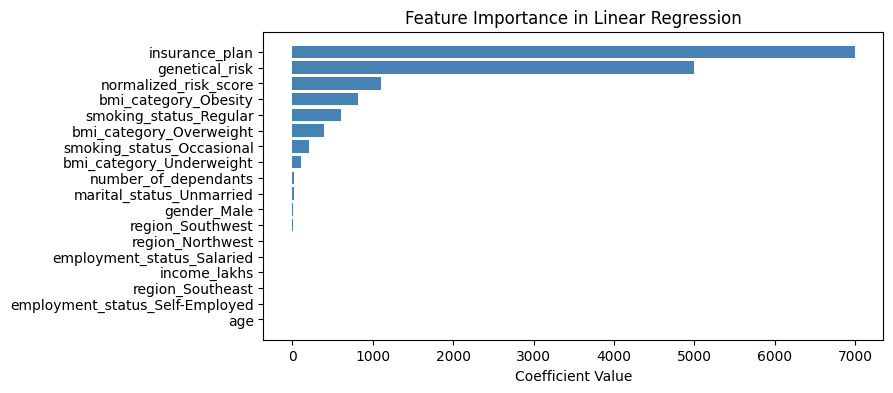

In [259]:
feature_importances = model_lr.coef_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df_sorted = coef_df.sort_values(by='Coefficients',ascending=True)
coef_df_sorted

plt.figure(figsize=(8,4))
plt.barh(coef_df_sorted.index, coef_df_sorted['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [262]:
model_rg = Ridge()
model_rg.fit(X_train, y_train)
train_score = model_rg.score(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score, test_score

(0.9882972960153418, 0.9887275909694276)

In [263]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score, test_score

(0.9925054809841402, 0.987729520869432)

**Applying RandomSearchCV for Best Hyperparameter to Fine Tune Model**

In [264]:
model_xgb = XGBRegressor()
params_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5,10,15]
}

random_search = RandomizedSearchCV(model_xgb, params_grid, n_iter=10, cv=3, scoring='r2', random_state=10)
random_search.fit(X_train, y_train)
print(random_search.best_params_)
random_search.best_score_


{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


0.9879225990497197

Here we'll choose Linear Regression coz it's easier to interprete

In [265]:
best_model = model_lr

### **Error Analysis**

In [266]:
# Let's check the level of error margin between the y_test and y_pred
y_pred = best_model.predict(X_test)

residuals = y_pred-y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})
results_df.head(4)

,actual,predicted,diff,diff_pct
12774,6238,6121.456891,-116.543109,-1.868277
14758,9462,9601.797510,139.797510,1.477463
13205,5152,5611.056493,459.056493,8.910258
14278,6988,7423.486322,435.486322,6.231916


<Axes: xlabel='diff_pct', ylabel='Count'>

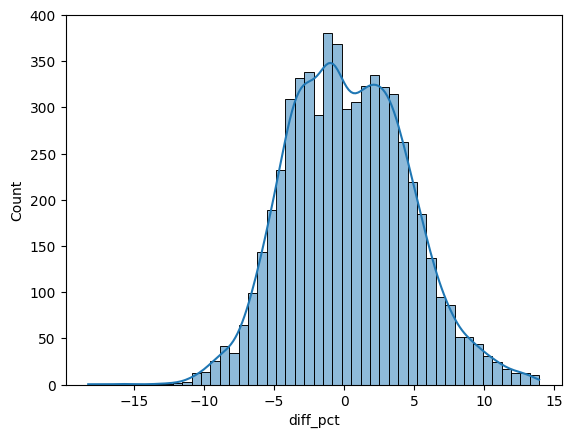

In [267]:
# It will be useful to see the distribution of the margin
sns.histplot(results_df['diff_pct'], kde=True)

In [268]:
# Having an error margin as high as 80% is not a good one

extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df

,actual,predicted,diff,diff_pct
12669,3985,4394.013230,409.013230,10.263820
2918,4517,5001.927338,484.927338,10.735606
17084,3562,3995.394401,433.394401,12.167165
7181,3630,4005.052340,375.052340,10.332020
12285,3532,3998.012625,466.012625,13.194015
...,...,...,...,...
1986,4633,5098.340369,465.340369,10.044040
8008,4902,5402.149195,500.149195,10.202962
9714,3624,4001.680590,377.680590,10.421650
7357,8608,7642.535233,-965.464767,-11.215901


In [269]:
results_df.shape

(6026, 4)

In [270]:
# Percentage of predictions with %_error above 10%
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

2.140723531364089

With this, we really don't need to do further analysis.

In [271]:
# Let's check further on those with high error margin, say >50
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

# The highest error is 87.5%, this is not good.

# We need to do further analysis to know what's responsible for the high margin errors

,actual,predicted,diff,diff_pct


In [272]:
X_test.index

Index([12774, 14758, 13205, 14278, 19351, 10622, 16391, 14799, 17184, 16348,
       ...
        8695,  9658, 14195,  1365,   399, 17652,  5807, 10298, 13316,  2583],
      dtype='int64', length=6026)

In [273]:
extreme_results_df.index

Index([12669,  2918, 17084,  7181, 12285, 13476, 15481,  2948,  4919, 15170,
       ...
       15166, 19580, 15664,  4204,  8692,  1986,  8008,  9714,  7357,  1534],
      dtype='int64', length=129)

In [274]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
12669,0.857143,0.000000,0.000000,0.0,0.0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.000000,0.151515,0.0,0.2,0.0,1,1,0,0,1,0,0,0,0,0,1,0
17084,1.000000,0.000000,0.353535,0.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,0
7181,0.571429,0.000000,0.161616,0.0,0.0,0.0,1,0,0,1,1,0,0,0,0,0,0,0
12285,0.428571,0.333333,0.232323,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0


### Export the Model

In [285]:
from joblib import dump
dump(best_model, "artifacts_/model_young.joblib")

['artifacts_/model_young.joblib']

In [288]:
cols_to_scale = ['age','income_lakhs', 'number_of_dependants' ,'income_level', 'insurance_plan', 'genetical_risk']

scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts_/scaler_young.joblib")

['artifacts_/scaler_young.joblib']